In [3]:
import sys
sys.path.append('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from codes.docs.analysis import data_preprocessing,genetic_file_preprocess
from codes.docs.analysis.nimagen import stats, visualisation, genes

In [4]:
european_volumetric_dataset_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [5]:
european_volumetric_dataset_term = european_volumetric_dataset_term[(european_volumetric_dataset_term['radiology_score']<5)&(european_volumetric_dataset_term['radiology_low_image_quality']==False)]

In [6]:
prs_imputed = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/PRS/asd/imputed_data/ASD_euro_batch2_imputed.gwas.all.score',
                                                                            column_prefix='ASD_PRS_imputed_Pt_')
prscs_imputed = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRScs/asd/ASD_imputed.profile',column_prefix='ASD_PRScs_imputed_')
prscs = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRScs/asd/plink.profile',column_prefix='ASD_PRScs_')
european_volumetric_dataset_term = european_volumetric_dataset_term.merge(prs_imputed,on='ID').merge(prscs[['ID','ASD_PRScs_SCORESUM']],on='ID').merge(prscs_imputed[['ID','ASD_PRScs_imputed_SCORESUM']],on='ID')

In [7]:
df = european_volumetric_dataset_term.copy()
print(df.shape)
ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers
df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)
print(df.shape)
df = df.drop(columns=['ASD_PRS_Pt_1e-07'])

(279, 203)
(273, 203)


In [8]:
pca, prs_pca, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS_Pt' in i],
    scaling=True,
    n_components=1
)
df['PRS_pca'] = prs_pca
pca, prs_pca_imputed, loading_matrix = stats.FeatureReduction.perform_PCA(
    df,
    dependentVar_cols=[i for i in df.columns if 'ASD_PRS_imputed_Pt' in i],
    scaling=True,
    n_components=1
)
df['PRS_pca_imputed'] = prs_pca_imputed

In [13]:
df['ID/Ses'] = 'sub-'+df['ID']+'/ses-'+df['Session'].astype('str')

In [20]:
# to_copy = df[['ID/Ses','sex','GA','PMA','TBV','PRS_pca','euro_Anc_PC1','euro_Anc_PC2','euro_Anc_PC3']].copy()
# to_copy.to_csv('../../codes/DrawEMVol/Jacobians_volume_ASDPCA_after_ancestry_outliers.txt',header=None,index=False)
# with open('../../codes/DrawEMVol/Jacobians_volume_ASDPCA_after_ancestry_outliers.txt','w') as file:
#     file.write(' '.join(["#"] + to_copy.columns.tolist()) + '\n')
#     to_copy.to_csv(file,header=None,index=None)

In [8]:
new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['lobe','hemisphere','gmwm2gether'],drop_duplicates=True)

In [9]:
# new_df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['lobe','hemisphere','gmwm2gether'])

new_df['Frontal lobe TTV'] = new_df['Imperial 36']
new_df['Parietal lobe TTV'] = new_df['Imperial 38']
new_df['Occipital lobe TTV'] = new_df['Imperial 15']
new_df['Temporal lobe TTV'] = new_df['Imperial 5']
new_df['Frontal+Temporal TTV'] = new_df['Frontal lobe TTV'] + new_df['Temporal lobe TTV']
new_df['Parietal+Occipital TTV'] = new_df['Parietal lobe TTV'] + new_df['Occipital lobe TTV']

In [12]:
AAL_FL=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,69,70]
AAL_OL=[43,44,45,46,47,48,49,50,51,52,53,54,55,56]
AAL_PL=[57,58,59,60,61,62,63,64,65,66,67,68]
AAL_TL = [81,82,83,84,85,86,87,88,89,90]

In [26]:
AAL_volumes = pd.read_csv('../../codes/DrawEMVol/AAL_volume_output.txt',delim_whitespace=True,header=None)
AAL_volumes = AAL_volumes.replace('label:',np.nan).dropna(axis=1)
AAL_volumes = AAL_volumes.drop_duplicates(0)
AAL_volumes.columns = ['ID/Ses'] + [f'AAL_{i}' for i in AAL_volumes.columns[1:]]
AAL_volumes = AAL_volumes[['ID/Ses']+[f'AAL_{i}' for i in AAL_FL+AAL_OL+AAL_PL+AAL_TL]]
AAL_volumes['ID'] = AAL_volumes['ID/Ses'].apply(lambda x: x.split('/')[0].replace('sub-',''))
AAL_volumes['Session'] = AAL_volumes['ID/Ses'].apply(lambda x: x.split('/')[1].replace('ses-','')).astype('int')

In [28]:
new_df = new_df.merge(AAL_volumes,on=['ID','Session'])

In [40]:
new_df['Frontal lobe AAL'] = new_df[[f'AAL_{i}' for i in AAL_FL]].sum(axis=1)
new_df['Temporal lobe AAL'] = new_df[[f'AAL_{i}' for i in AAL_TL]].sum(axis=1)
new_df['Occipital lobe AAL'] = new_df[[f'AAL_{i}' for i in AAL_OL]].sum(axis=1)
new_df['Parietal lobe AAL'] = new_df[[f'AAL_{i}' for i in AAL_PL]].sum(axis=1)

In [41]:
euro_result = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(new_df,
                                                                                        thresholds=['PRS_pca','PRS_pca_imputed','ASD_PRScs_SCORESUM','ASD_PRScs_imputed_SCORESUM'],
                                                                                        cat_independentVar_cols=['sex'],
                                           cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
                                           dependentVar_cols=[i for i in new_df.columns if 'lobe AAL' in i])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


In [85]:
df_cortical_regions = data_preprocessing.Volumes.Imperial.get_segment(df,lobe=['frontal','temporal','occipital','parietal'])

In [119]:
_, euro_result_individual_cortical_region = stats.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
    dependentVar_cols=df_cortical_regions,
    )

In [120]:
to_plot_values = euro_result_individual_cortical_region[["standardize(Q('PRS_pca'))_coef"]].copy()
plot_labels = [int(i.replace('Imperial ','')) for i in to_plot_values.index]
prs_plot_value_values = to_plot_values.values.reshape(-1).tolist()
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 

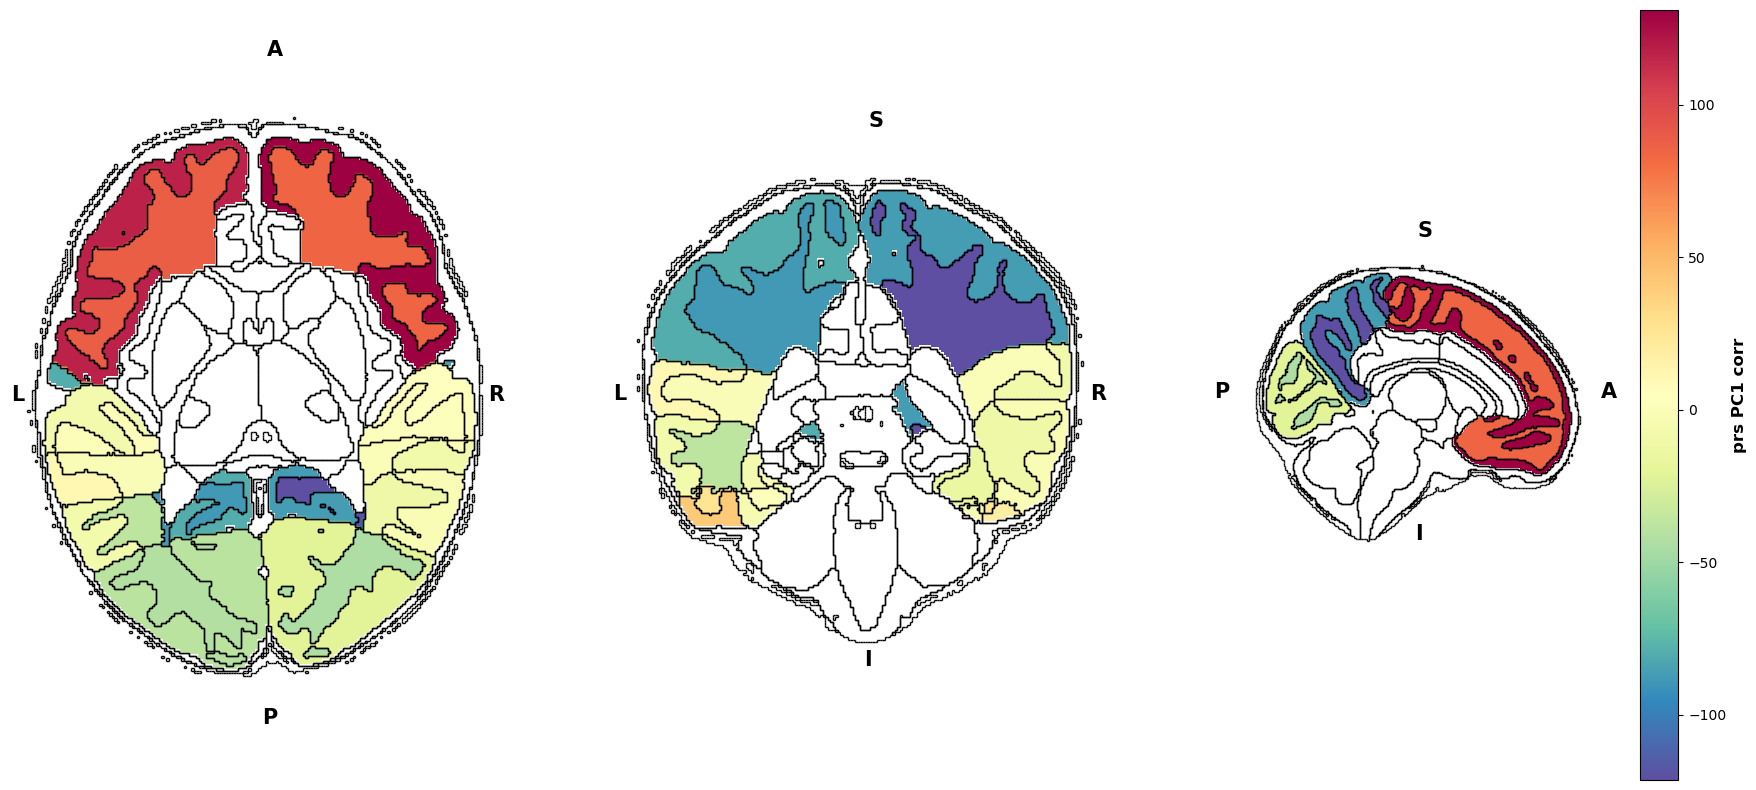

In [121]:
_,_ = visualisation.Brainmap.plot_segmentation(
    # atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    cb_title='prs PC1 corr')

In [122]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')

In [123]:
standardized_ROIs_coord = ROIs_coord.copy()
standardized_ROIs_coord[['X','Y','Z']] = stats.StandardScaler().fit_transform(ROIs_coord[['X_vox','Y_vox','Z_vox']])
standardized_ROIs_coord = standardized_ROIs_coord.set_index('Label')

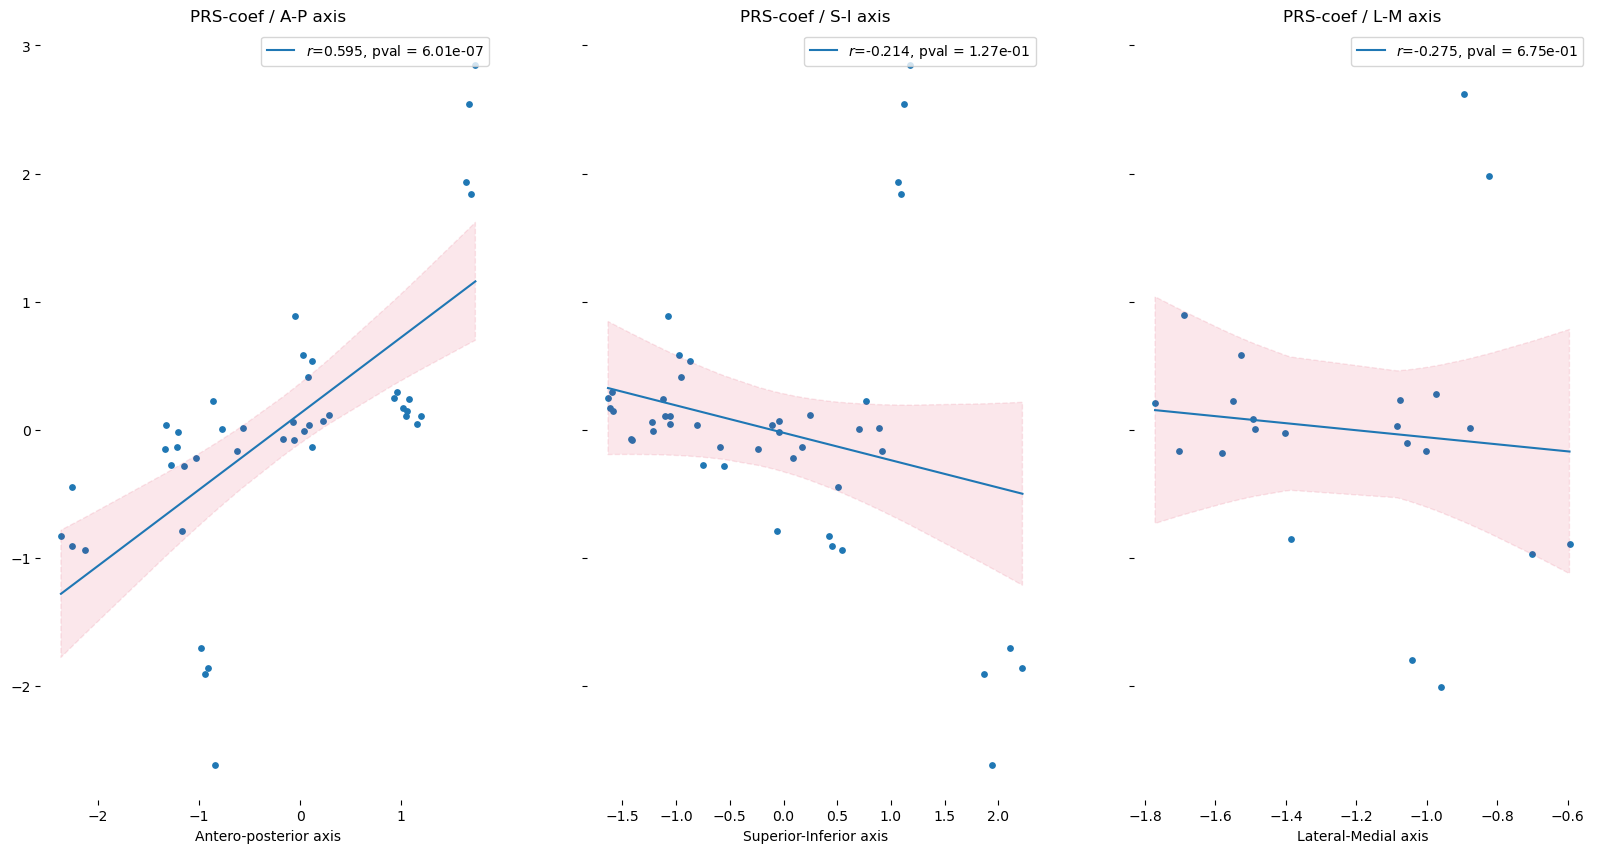

In [124]:
standardized_ROIs_coord = ROIs_coord.copy()
standardized_ROIs_coord[['X','Y','Z']] = stats.StandardScaler().fit_transform(ROIs_coord[['X_vox','Y_vox','Z_vox']])
standardized_ROIs_coord = standardized_ROIs_coord.set_index('Label')
fig,axes = plt.subplots(1,3,figsize=(20,10),sharey=True)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[prs_plot_values.keys(),'Y'],
                                  y=prs_plot_value_values, 
                                  # annotate=[Imperial_labels[i]['abbr'] for i in loading_matrix.index], 
                                  xlabel='Antero-posterior axis',scaling='y',return_stats=True,legend=True,title='PRS-coef / A-P axis',ax=axes[0],
                                 legend_loc='upper right',markersize=15)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[prs_plot_values.keys(),'Z'],
                                  y=prs_plot_value_values,
#                                   annotate=[Imperial_labels[i]['abbr'] for i in loading_matrix.index],
                                  xlabel='Superior-Inferior axis',scaling='y',return_stats=True, legend=True,title='PRS-coef / S-I axis',ax=axes[1],
                                 legend_loc='upper right',markersize=15)
left_right_values_to_plot = data_preprocessing.Volumes.Imperial.get_segment({f'Imperial {k}':v for k,v in prs_plot_values.items()},side='left')
left_right_values_to_plot = {int(k.replace('Imperial ','')):v for k,v in left_right_values_to_plot.items()}
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[left_right_values_to_plot.keys(),'X'],
                                  y=[i for i in left_right_values_to_plot.values()], 
#                                   annotate=[Imperial_labels[i]['abbr'] for i in data_preprocessing.Volumes.Imperial.get_segment(pd.DataFrame(loading_matrix[pc]),col='index',side=['left']).index],
                                  # ylabel='PC8~BrainVol corr', 
                                  xlabel='Lateral-Medial axis',scaling='y',return_stats=True, legend=True,title='PRS-coef / L-M axis',ax=axes[2],
                                 legend_loc='upper right',markersize=15)
sns.despine(bottom=True,right=True,left=True,top=True)

In [380]:
_, euro_AAL = stats.MassUnivariate.mass_univariate(
    new_df,
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['PRS_pca','GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in new_df.columns if 'AAL' in i]
    )

In [381]:
euro_AAL.sort_values(by="standardize(Q('PRS_pca'))_pval")

,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(Q('PRS_pca'))_coef,standardize(Q('PRS_pca'))_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval
AAL_20,3320.294395,1.671862e-246,4.262535,0.905949,48.594294,0.003054,34.551491,0.097374,-261.280660,1.949380e-15,445.644225,9.776377e-43,15.709784,0.341251,-12.808567,0.434491,0.263426,0.987202
AAL_28,944.452492,8.264381e-224,-11.635038,0.354331,16.046894,0.004893,13.475028,0.063308,-96.692708,4.861512e-17,143.365762,2.553505e-38,13.697640,0.017578,-8.363423,0.143022,4.963527,0.385341
AAL_69,1239.075694,2.210573e-183,-3.285997,0.889674,30.240491,0.004955,13.890468,0.309322,-134.900404,1.710762e-10,187.087257,4.518928e-22,3.480602,0.747925,-4.166815,0.698473,12.486800,0.247462
AAL_70,747.414645,5.153143e-188,1.579835,0.908192,17.046559,0.006147,6.890223,0.383093,-64.466621,9.328764e-08,90.289935,1.415924e-16,1.952592,0.755236,-8.730157,0.161218,0.418947,0.946438
AAL_27,1227.976936,4.266673e-239,-9.772882,0.492934,17.673196,0.006304,6.930315,0.398888,-116.260310,1.124390e-18,196.151060,1.974389e-49,6.242515,0.338261,-0.510745,0.937065,-1.206513,0.852422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAL_84,1274.862838,5.321142e-230,-29.852178,0.063503,0.485767,0.946435,8.786784,0.342020,-95.412097,2.942372e-11,147.067823,8.791028e-28,9.561916,0.192807,5.385890,0.459643,-1.639058,0.822334
AAL_54,1366.716643,1.604488e-197,4.022188,0.861100,0.616100,0.952602,5.674132,0.668427,-120.084290,3.815922e-09,241.307595,5.977456e-34,-5.291944,0.614639,0.046875,0.996416,-8.017435,0.443804
AAL_67,8038.555345,6.045895e-276,10.155467,0.880184,0.858269,0.977461,64.873761,0.095574,-664.384340,4.103591e-25,1117.250237,1.936181e-62,28.469930,0.355686,11.282425,0.712272,25.256804,0.410494
AAL_82,5736.040543,1.329117e-258,-89.528169,0.110792,-0.704217,0.977755,-16.889430,0.600840,-424.766066,1.279979e-16,702.921156,1.125308e-43,6.223718,0.807961,-33.564641,0.187575,-7.148443,0.779200


In [382]:
to_plot_values = euro_AAL[["standardize(Q('PRS_pca'))_coef"]].copy()

In [383]:
plot_labels = [int(i.replace('AAL_','')) for i in to_plot_values.index]
prs_plot_value_values = to_plot_values.values.reshape(-1).tolist()
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 

(<Figure size 2200x1000 with 4 Axes>,
 defaultdict(dict,
             {'sagittal': {'ax': <Axes: >,
               'atlas': array([[nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      ...,
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan]]),
               'original_atlas': array([[nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      ...,
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan],
                      [nan, nan, nan, ..., nan, nan, nan]]),
               'im': <matplotlib.image.AxesImage at 0x7fc866a37d90>},
              'axial': {'ax': <Axes: 

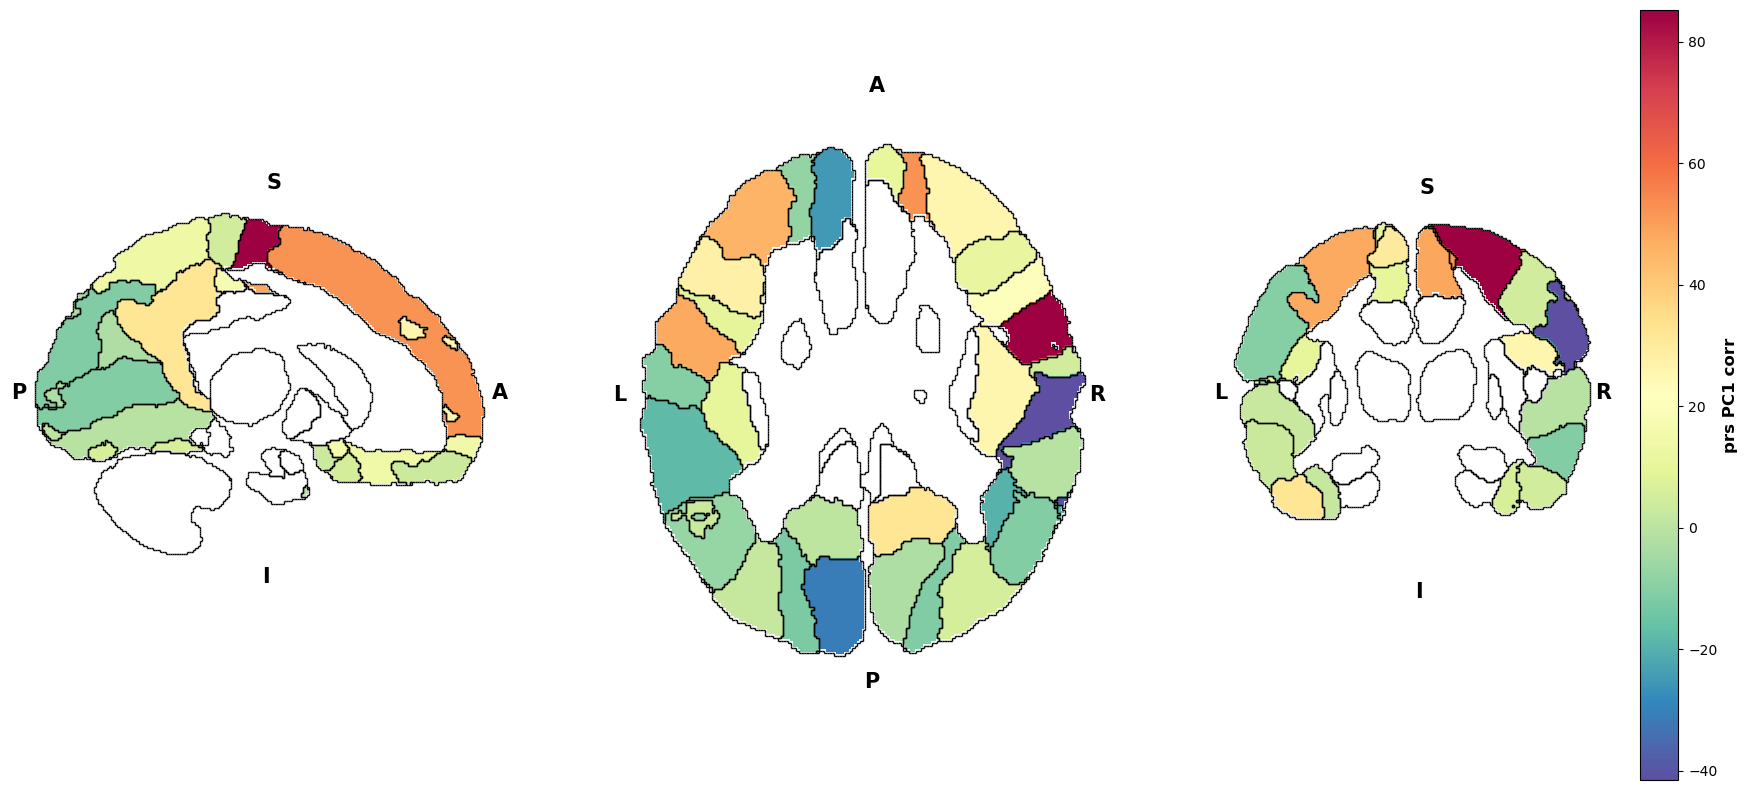

In [386]:
visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    cb_title='prs PC1 corr')

In [58]:
mean_jacobians = pd.read_csv('../../codes/DrawEMVol/mean_Jacobians/mean_jacobians_drawEM.txt',sep=' ',header=None)
mean_jacobians.columns = ['ID/Ses']+[f'Imperial {i}' for i in mean_jacobians.columns.tolist()[1:]]
mean_jacobians['ID'] =  mean_jacobians['ID/Ses'].apply(lambda x: x.split('_')[0].replace('sub-',''))
mean_jacobians['Session'] =  mean_jacobians['ID/Ses'].apply(lambda x: x.split('_')[1].replace('ses-','')).astype('int')

In [59]:
mean_jacobians = mean_jacobians.merge(df[['ID','GA','PMA','sex','TBV','ICV']+ancestry+[i for i in df.columns if 'PRS' in i]],on='ID')

In [61]:
mean_jacobians_results = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    mean_jacobians,
    thresholds=['PRS_pca'],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','ICV']+ancestry,
    dependentVar_cols=[i for i in mean_jacobians.columns if 'Imperial ' in i]
)

 ... (more hidden) ...


In [62]:
mean_jacobians_results.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(ICV)_coef,standardize(ICV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
35,Imperial 36,-0.019723,1.982219e-13,-0.008289,0.026854,-0.003253,0.136995,-0.006812,0.036065,0.017152,3.522155e-09,0.002212,0.204978,-0.002479,0.152802,0.001353,0.435662,0.005696,0.001013,PRS_pca
80,Imperial 81,-0.040485,1.549631e-20,0.011632,0.048093,0.000312,0.927638,0.000448,0.929873,-0.001162,7.925372e-01,0.001760,0.521132,0.006859,0.012245,0.000487,0.858425,-0.008148,0.002752,PRS_pca
76,Imperial 77,-0.023797,8.697373e-05,0.014758,0.092341,-0.001134,0.824701,-0.001983,0.793898,-0.001141,8.625059e-01,0.002416,0.554639,0.006351,0.118554,-0.002918,0.473506,-0.009124,0.024049,PRS_pca
70,Imperial 71,-0.021785,4.575618e-04,0.007439,0.408321,-0.006551,0.214119,-0.002474,0.751282,0.000161,9.810803e-01,0.006673,0.113290,0.005384,0.197731,0.002393,0.567438,-0.008861,0.032984,PRS_pca
38,Imperial 39,-0.008090,9.091609e-03,-0.009547,0.034984,-0.000120,0.963838,0.004725,0.228107,0.002492,4.635323e-01,-0.000690,0.743322,0.003588,0.087404,0.001075,0.608577,-0.004247,0.041460,PRS_pca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Imperial 63,-0.006362,2.714372e-01,0.021702,0.010745,-0.002899,0.558380,0.004642,0.527368,-0.016443,1.033810e-02,0.005144,0.193972,0.001202,0.759421,0.002718,0.489777,-0.000249,0.948921,PRS_pca
19,Imperial 20,-0.006259,2.330000e-01,0.005598,0.465652,0.005056,0.260870,0.000381,0.954427,-0.006991,2.270772e-01,0.007852,0.029278,-0.000468,0.895365,0.002803,0.432458,-0.000165,0.962731,PRS_pca
61,Imperial 62,-0.021141,5.715450e-03,0.022005,0.048510,0.007337,0.260126,-0.013670,0.157315,-0.003987,6.341376e-01,-0.000527,0.919228,-0.001324,0.797499,-0.003081,0.551329,-0.000116,0.981848,PRS_pca
25,Imperial 26,-0.006992,4.334401e-01,0.010459,0.423251,-0.000200,0.979088,0.001909,0.866215,0.002862,7.711227e-01,0.005641,0.355774,0.002148,0.723021,-0.010031,0.099500,-0.000100,0.986661,PRS_pca


In [65]:
mean_jacobians_cortical_regions = data_preprocessing.Volumes.Imperial.get_segment(mean_jacobians,lobe=['frontal','temporal','occipital','parietal'])

In [66]:
mean_jacobians_results = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    mean_jacobians,
    thresholds=['PRS_pca'],
    cat_independentVar_cols=['sex'],
    cont_independentVar_cols=['GA','PMA','TBV']+ancestry,
    dependentVar_cols=[i for i in mean_jacobians_cortical_regions.columns if 'Imperial ' in i]
)

 ... (more hidden) ...


In [73]:
to_plot_values_jacobians = mean_jacobians_results[["PRS_coef"]].copy()
plot_labels_jacobians = [int(i.replace('Imperial ','')) for i in mean_jacobians_results['Connection']]
prs_plot_value_values_jacobians = to_plot_values_jacobians.values.reshape(-1).tolist()
prs_plot_values_jacobians = dict(zip(plot_labels_jacobians,prs_plot_value_values_jacobians)) 

In [69]:
mean_jacobians_results.sort_values(by='PRS_pval')

,Connection,Intercept_coef,Intercept_pval,C(sex)[T.male]_coef,C(sex)[T.male]_pval,standardize(GA)_coef,standardize(GA)_pval,standardize(PMA)_coef,standardize(PMA)_pval,standardize(TBV)_coef,standardize(TBV)_pval,standardize(Q('euro_Anc_PC1'))_coef,standardize(Q('euro_Anc_PC1'))_pval,standardize(Q('euro_Anc_PC2'))_coef,standardize(Q('euro_Anc_PC2'))_pval,standardize(Q('euro_Anc_PC3'))_coef,standardize(Q('euro_Anc_PC3'))_pval,PRS_coef,PRS_pval,threshold
14,Imperial 36,-0.019695,7.542267e-13,-0.008342,0.031485,-0.003435,0.123468,-0.005477,0.099064,0.015556,1.476514e-07,0.002427,0.169983,-0.002656,0.130602,0.001452,0.409174,0.005887,0.000823,PRS_pca
42,Imperial 81,-0.038952,5.482201e-19,0.008642,0.149493,0.001490,0.665610,-0.003955,0.441126,0.003873,3.863283e-01,0.001352,0.621120,0.006977,0.010696,0.000309,0.909728,-0.007970,0.003394,PRS_pca
35,Imperial 71,-0.021805,5.291469e-04,0.007477,0.416034,-0.006568,0.215441,-0.002406,0.760159,0.000082,9.905115e-01,0.006680,0.112591,0.005381,0.197738,0.002396,0.566849,-0.008861,0.033195,PRS_pca
17,Imperial 39,-0.008458,7.131973e-03,-0.008829,0.056403,-0.000429,0.871698,0.005965,0.132329,0.001065,7.570328e-01,-0.000564,0.789076,0.003536,0.092126,0.001130,0.590307,-0.004266,0.041003,PRS_pca
15,Imperial 37,-0.013304,2.983288e-06,-0.008486,0.040189,-0.004007,0.092232,-0.003235,0.360195,0.013702,1.214415e-05,0.001419,0.451408,-0.003132,0.094840,0.002238,0.233343,0.003651,0.050156,PRS_pca
16,Imperial 38,-0.016271,8.551984e-07,-0.005829,0.222406,-0.000364,0.894769,0.007082,0.084325,-0.001233,7.291729e-01,0.002432,0.265347,0.003622,0.095341,0.000126,0.953804,-0.004020,0.062551,PRS_pca
43,Imperial 82,-0.040591,1.477369e-20,0.009579,0.107073,-0.000415,0.903323,-0.003096,0.542803,0.001915,6.653313e-01,-0.001013,0.708718,0.006653,0.014011,0.002483,0.358066,-0.004920,0.066637,PRS_pca
31,Imperial 66,-0.015653,6.968621e-03,0.003512,0.679816,0.006266,0.201954,-0.010971,0.133581,0.009315,1.433507e-01,0.000957,0.805641,0.002408,0.533227,0.003199,0.409129,-0.005621,0.143755,PRS_pca
2,Imperial 13,-0.050120,1.494649e-12,-0.007307,0.463877,0.009474,0.100011,0.007758,0.364672,0.002802,7.066398e-01,-0.004445,0.329887,-0.005696,0.208952,0.003648,0.421876,0.006555,0.145647,PRS_pca
37,Imperial 73,-0.051861,1.349227e-08,-0.001393,0.915185,-0.008635,0.252383,0.001544,0.890496,-0.006128,5.302925e-01,-0.008754,0.143922,0.009072,0.127341,0.007861,0.187358,-0.008582,0.146338,PRS_pca


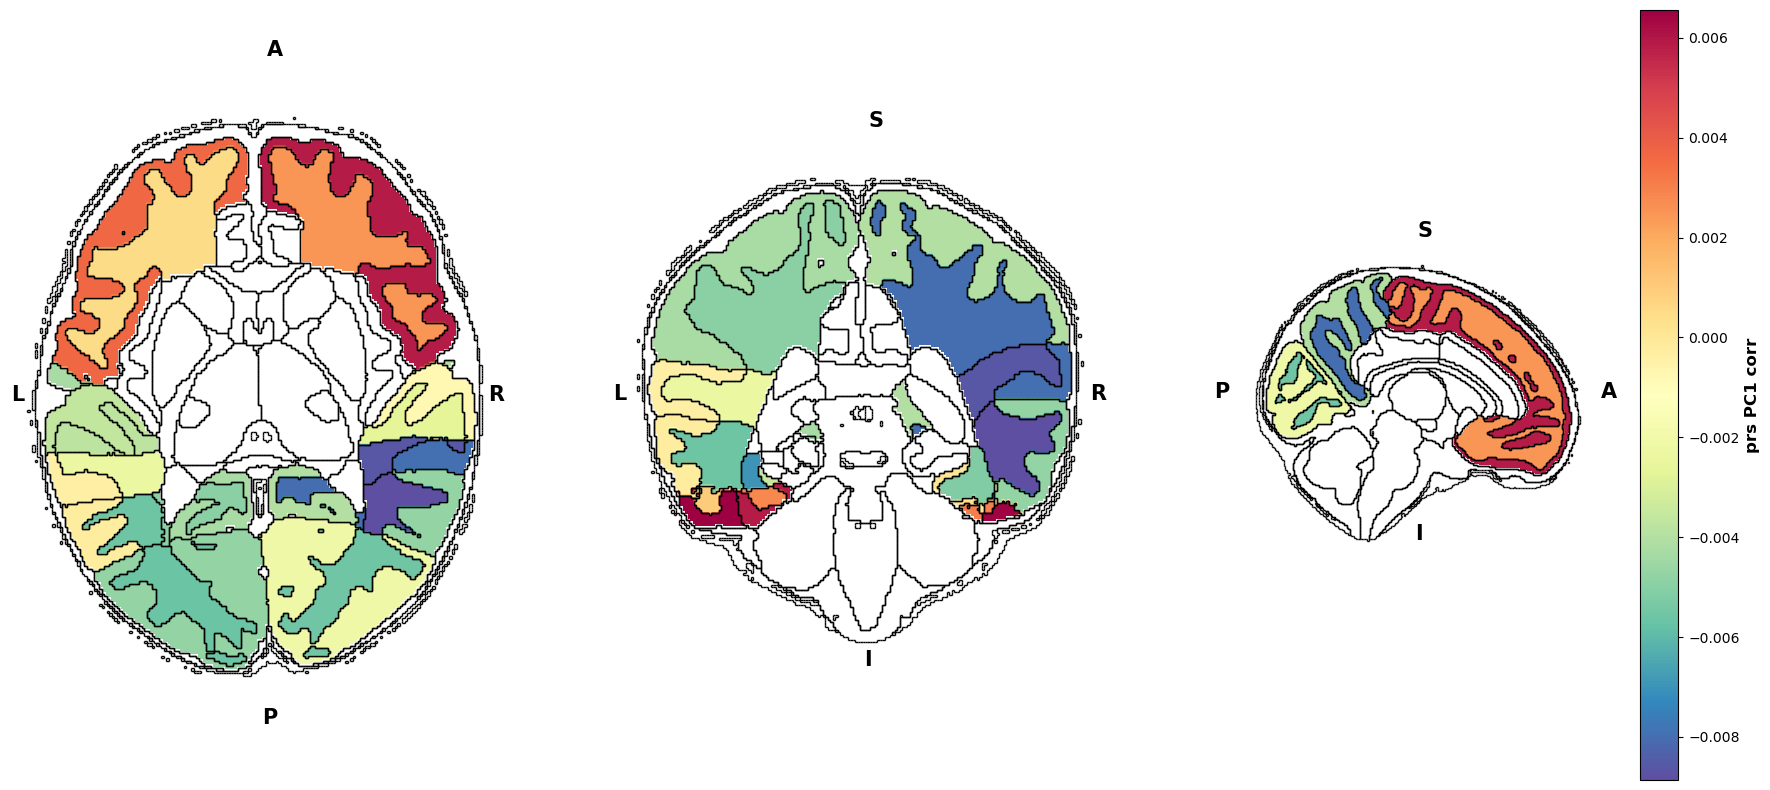

In [74]:
_,_ = visualisation.Brainmap.plot_segmentation(
    # atlas_slice=120,
    plot_values=prs_plot_values_jacobians,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    cb_title='prs PC1 corr')

In [79]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')

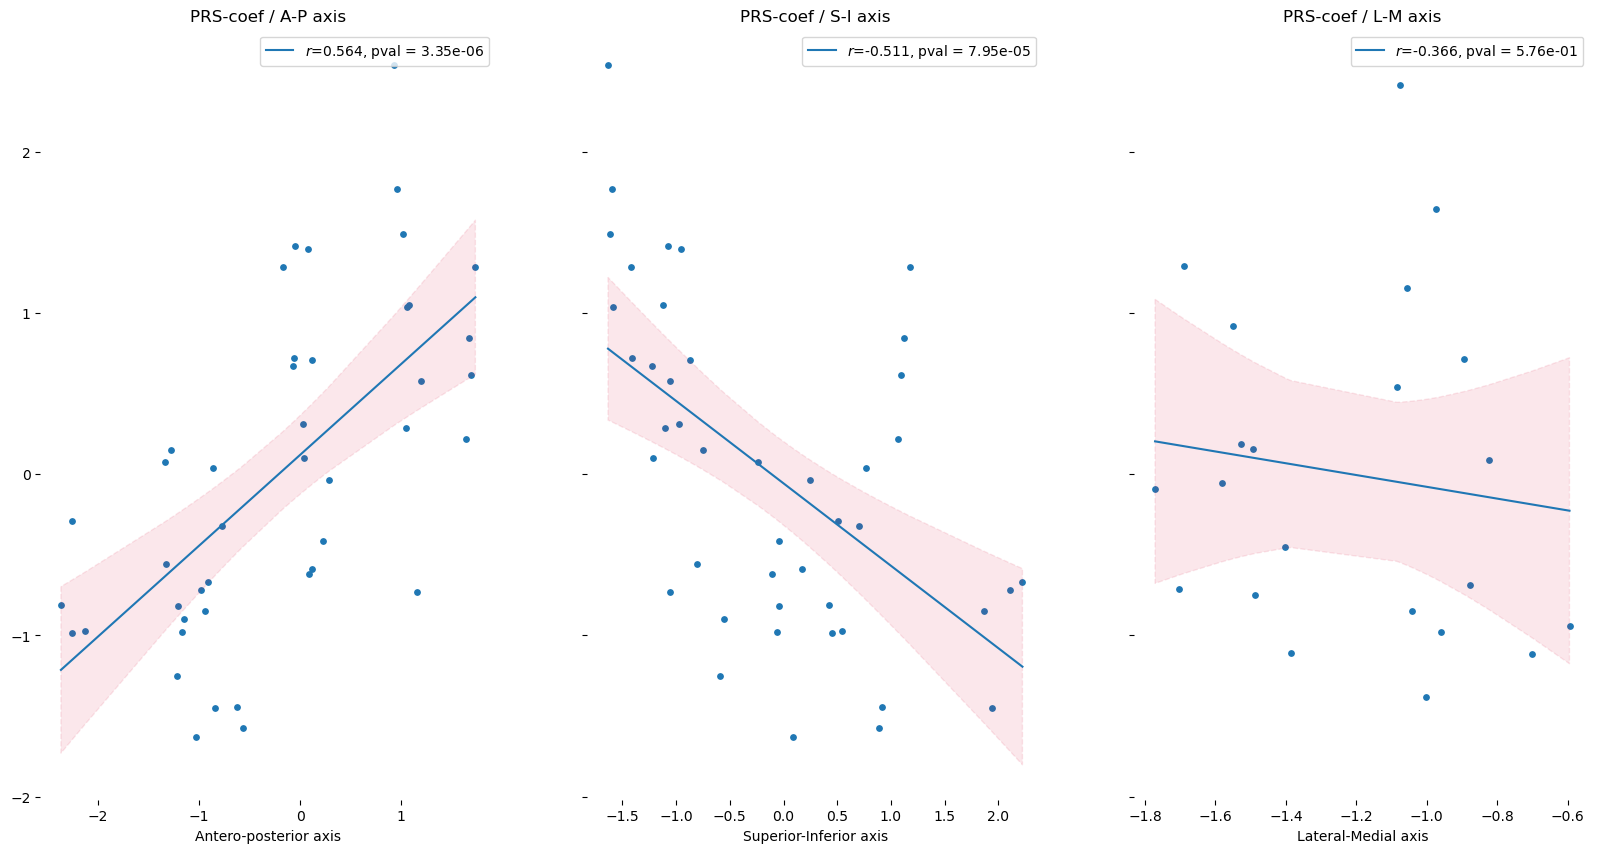

In [80]:
standardized_ROIs_coord = ROIs_coord.copy()
standardized_ROIs_coord[['X','Y','Z']] = stats.StandardScaler().fit_transform(ROIs_coord[['X_vox','Y_vox','Z_vox']])
standardized_ROIs_coord = standardized_ROIs_coord.set_index('Label')
fig,axes = plt.subplots(1,3,figsize=(20,10),sharey=True)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[prs_plot_values_jacobians.keys(),'Y'],
                                  y=prs_plot_value_values_jacobians, 
                                  # annotate=[Imperial_labels[i]['abbr'] for i in loading_matrix.index], 
                                  xlabel='Antero-posterior axis',scaling='y',return_stats=True,legend=True,title='PRS-coef / A-P axis',ax=axes[0],
                                 legend_loc='upper right',markersize=15)
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[prs_plot_values_jacobians.keys(),'Z'],
                                  y=prs_plot_value_values_jacobians,
#                                   annotate=[Imperial_labels[i]['abbr'] for i in loading_matrix.index],
                                  xlabel='Superior-Inferior axis',scaling='y',return_stats=True, legend=True,title='PRS-coef / S-I axis',ax=axes[1],
                                 legend_loc='upper right',markersize=15)
left_right_values_to_plot = data_preprocessing.Volumes.Imperial.get_segment({f'Imperial {k}':v for k,v in prs_plot_values_jacobians.items()},side='left')
left_right_values_to_plot = {int(k.replace('Imperial ','')):v for k,v in left_right_values_to_plot.items()}
visualisation.SimplePlots.Scatter(x=standardized_ROIs_coord.loc[left_right_values_to_plot.keys(),'X'],
                                  y=[i for i in left_right_values_to_plot.values()], 
#                                   annotate=[Imperial_labels[i]['abbr'] for i in data_preprocessing.Volumes.Imperial.get_segment(pd.DataFrame(loading_matrix[pc]),col='index',side=['left']).index],
                                  # ylabel='PC8~BrainVol corr', 
                                  xlabel='Lateral-Medial axis',scaling='y',return_stats=True, legend=True,title='PRS-coef / L-M axis',ax=axes[2],
                                 legend_loc='upper right',markersize=15)
sns.despine(bottom=True,right=True,left=True,top=True)